# HSCT survival: Weibull accelerated failure model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

feature_pval_cutoff=0.001

# Dataset definition file
datasets_definitions_file=f'{config.DATA_PATH}/processed/02.1-dataset_definitions.pkl'

# Feature type definitions file
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'

# Output file
survival_probabilities_file=f'{config.DATA_PATH}/processed/02.2-weibullAFT_survival.parquet'


## 1. Load data

Datasets:

 Nominal one-hot/ordinal encoded, NANs encoded
 Nominal one-hot/ordinal encoded, NANs imputed
 All ordinal encoded, NAN encoded
 All ordinal encoded, NAN imputed
 Binary target encoded
 Continuous target encoded

Feature types:

 Interval: ['donor_age', 'age_at_hct']

 Ordinal: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

 Nominal: ['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 't

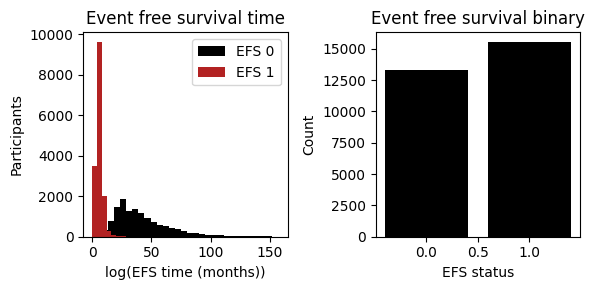

Raw data shape: (28800, 59)


In [2]:
# Load dataset definitions
with open(datasets_definitions_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print('Datasets:\n')
for description, filepath in datasets.items():
    print(f' {description}')

# Load feature definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types=pickle.load(input_file)

print('\nFeature types:\n')
for feature_type, features in feature_types.items():
    print(f' {feature_type}: {features}\n')

# Load the data
data_df_file=datasets['All ordinal encoded, NAN imputed']
raw_data_df=pd.read_parquet(data_df_file)

# Take the log of efs_time
#raw_data_df['efs_time']=np.log(raw_data_df['efs_time'])

# Take a quick look at the target
efs_neg_df=raw_data_df[raw_data_df['efs'] == 0]
efs_pos_df=raw_data_df[raw_data_df['efs'] == 1]

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(6,3))
axs=axs.flatten()

axs[0].set_title('Event free survival time')
axs[0].hist(efs_neg_df['efs_time'], bins=30, color='black', label='EFS 0')
axs[0].hist(efs_pos_df['efs_time'], bins=30, color='firebrick', label='EFS 1')
axs[0].set_xlabel('log(EFS time (months))')
axs[0].set_ylabel('Participants')
axs[0].legend(loc='upper right')

axs[1].set_title('Event free survival binary')
axs[1].bar(raw_data_df['efs'].value_counts().index, raw_data_df['efs'].value_counts(), color='black')
axs[1].set_xlabel('EFS status')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f'Raw data shape: {raw_data_df.shape}')

## 2. Data preparation

### 2.1. Train-test split

In [3]:
training_df, testing_df=train_test_split(raw_data_df, test_size=0.33, random_state=315)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

### 2.2. Save and remove training & testing race group

In [4]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

## 3. Weibull AFT model

### 3.1. Naive model

In [5]:
waft_model=WeibullAFTFitter()
waft_model.fit(training_df, duration_col='efs_time', event_col='efs')

<lifelines.WeibullAFTFitter: fitted with 19296 total observations, 8876 right-censored observations>

In [6]:
waft_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 19296 total observations, 8876 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
   number of observations = 19296
number of events observed = 10420
           log-likelihood = -46358.51
         time fit was run = 2025-02-23 16:08:58 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                               
lambda_ age_at_hct             -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
        arrhythmia             -0.03      0.97      0.03           -0.09            0.03                0.91                1.03
        cardiac                -0.24      0.79      0.03           -0.29           -0.19                0.75                0.83
        cmv_status             -0.00      1.00      0.02           -0.04            0.04                0.96                1.04
        comorbidity_score      -0.05      0.95      0.01           -0.07           -0.04                0.94                0.96
        conditioning_intensity -0.06      0.94      0.01           -0.09           -0.04                0.92                0.96
        cyto_score              0.01      1.01      0.01           -0.02            0.03                0.98                1.03
        cyto_score_detail       0.04      1.04      0.02            0.00            0.07                1.00                1.07
        diabetes               -0.10      0.90      0.02           -0.14           -0.06                0.87                0.94
        donor_age              -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        donor_related           0.10      1.10      0.02            0.06            0.13                1.07                1.14
        dri_score              -0.07      0.93      0.01           -0.08           -0.05                0.92                0.95
        ethnicity               0.01      1.01      0.03           -0.05            0.08                0.95                1.08
        graft_type              0.38      1.47      0.07            0.25            0.52                1.28                1.68
        gvhd_proph             -0.02      0.98      0.01           -0.03           -0.01                0.97                0.99
        hepatic_mild           -0.06      0.94      0.03           -0.12           -0.01                0.89                0.99
        hepatic_severe          0.22      1.25      0.04            0.15            0.29                1.16                1.34
        hla_high_res_10         0.00      1.00      0.01           -0.01            0.02                0.99                1.02
        hla_high_res_6         -0.08      0.92      0.07           -0.22            0.05                0.80                1.05
        hla_high_res_8          0.08      1.08      0.05           -0.02            0.17                0.98                1.19
        hla_low_res_10          0.04      1.04      0.01            0.02            0.05                1.02                1.05
        hla_low_res_6          -0.15      0.86      0.08           -0.31            0.02                0.73                1.02
        hla_low_res_8           0.08      1.08      0.06           -0.04            0.19                0.96                1.21
        hla_match_a_high        0.06      1.06      0.05           -0.04            0.16                0.96                1.17
        hla_match_a_low         0.33      1.39      0.05            0.23            0.44                1.25                1.55
        hla_match_b_high        0.01      1.01      0.05           -0.09            0.12                0.92                1.12
        hla_match_b_low        -0.05      0.95     

### 3.2. Feature p-values

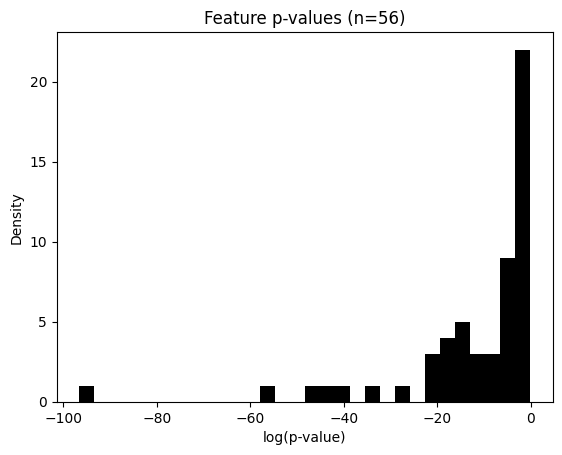

Significant features at alpha = 0.05: 34
Significant features at alpha = 0.001: 25


In [7]:
feature_pvals=waft_model.summary['p']
feature_pvals=feature_pvals.droplevel(0)
feature_pvals.drop('Intercept', axis=0, inplace=True)

plt.title(f'Feature p-values (n={len(feature_pvals)})')
plt.hist(np.log(feature_pvals), color='black', bins=30)
plt.xlabel('log(p-value)')
plt.ylabel('Density')
plt.show()

significant_features=feature_pvals[feature_pvals < 0.05]
print(f'Significant features at alpha = 0.05: {len(significant_features)}')

significant_features=feature_pvals[feature_pvals < 0.001]
print(f'Significant features at alpha = 0.001: {len(significant_features)}')

### 3.3. Feature selections

In [8]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

### 3.4. Re-train model

In [9]:
waft_model=WeibullAFTFitter()
waft_model.fit(training_significant_features_df, duration_col='efs_time', event_col='efs')
waft_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 19296 total observations, 8876 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
   number of observations = 19296
number of events observed = 10420
           log-likelihood = -46406.92
         time fit was run = 2025-02-23 16:09:04 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                               
lambda_ age_at_hct             -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
        cardiac                -0.24      0.79      0.03           -0.29           -0.19                0.75                0.83
        comorbidity_score      -0.06      0.94      0.01           -0.07           -0.05                0.93                0.95
        conditioning_intensity -0.06      0.94      0.01           -0.09           -0.04                0.92                0.96
        diabetes               -0.10      0.90      0.02           -0.14           -0.07                0.87                0.94
        donor_related           0.09      1.10      0.02            0.06            0.12                1.07                1.13
        dri_score              -0.07      0.93      0.01           -0.09           -0.05                0.92                0.95
        graft_type              0.39      1.48      0.07            0.26            0.53                1.29                1.70
        hepatic_severe          0.22      1.25      0.04            0.15            0.29                1.17                1.34
        hla_low_res_10          0.04      1.04      0.01            0.02            0.05                1.03                1.05
        hla_match_a_low         0.27      1.30      0.03            0.20            0.33                1.22                1.39
        hla_match_dqb1_high    -0.18      0.83      0.03           -0.25           -0.12                0.78                0.89
        hla_match_dqb1_low     -0.21      0.81      0.04           -0.29           -0.14                0.75                0.87
        in_vivo_tcd             0.25      1.28      0.02            0.21            0.28                1.24                1.32
        karnofsky_score         0.08      1.08      0.01            0.06            0.09                1.06                1.10
        mrd_hct                 0.08      1.09      0.02            0.04            0.13                1.04                1.13
        peptic_ulcer            0.23      1.25      0.05            0.13            0.32                1.14                1.38
        prim_disease_hct        0.02      1.02      0.00            0.01            0.03                1.01                1.03
        prod_type              -0.30      0.74      0.07           -0.43           -0.16                0.65                0.85
        psych_disturb          -0.12      0.89      0.02           -0.16           -0.08                0.85                0.92
        pulm_moderate          -0.07      0.93      0.02           -0.11           -0.03                0.90                0.97
        pulm_severe            -0.18      0.83      0.03           -0.24           -0.13                0.79                0.88
        sex_match               0.06      1.07      0.01            0.04            0.09                1.04                1.09
        tbi_status              0.09      1.10      0.02            0.06            0.13                1.06                1.13
        tce_match              -0.10      0.91      0.02           -0.13           -0.07                0.88                0.93
        Intercept               4.13     61.88      0.13            3.88            4.38               48.19               79.47
rho_    Intercept              -0.39      0.68     

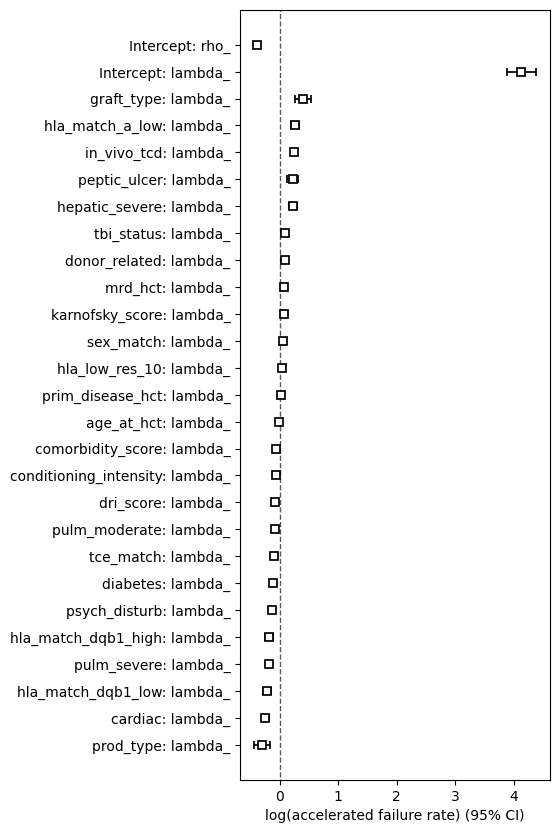

In [10]:
fig=plt.figure(figsize=[4,10])
waft_model.plot(figure=fig)
plt.show()

## 4. Survival forecasting

In [11]:
# Predict new survival function for all subjects
training_survival_functions=waft_model.predict_survival_function(training_significant_features_df)
training_expectations=waft_model.predict_expectation(training_significant_features_df)
training_survival_df=training_labels_df[['efs', 'efs_time']].copy()
training_survival_df['Survival']=training_survival_functions.iloc[-1]
training_survival_df['Expectation']=training_expectations

# Predict new survival function for all subjects
testing_survival_functions=waft_model.predict_survival_function(testing_significant_features_df)
testing_expectations=waft_model.predict_expectation(testing_significant_features_df)
testing_survival_df=testing_labels_df[['efs', 'efs_time']].copy()
testing_survival_df['Survival']=testing_survival_functions.iloc[-1]
testing_survival_df['Expectation']=testing_expectations

training_survival_df.head()

,efs,efs_time,Survival,Expectation
ID,,,,
1044,1.0,10.592,0.103086,61.042196
9306,0.0,40.171,0.361570,199.938838
24307,1.0,6.128,0.292366,151.108006
1058,0.0,125.803,0.003861,16.301462
24177,0.0,39.575,0.460947,299.067945


### 4.1. Survival curves

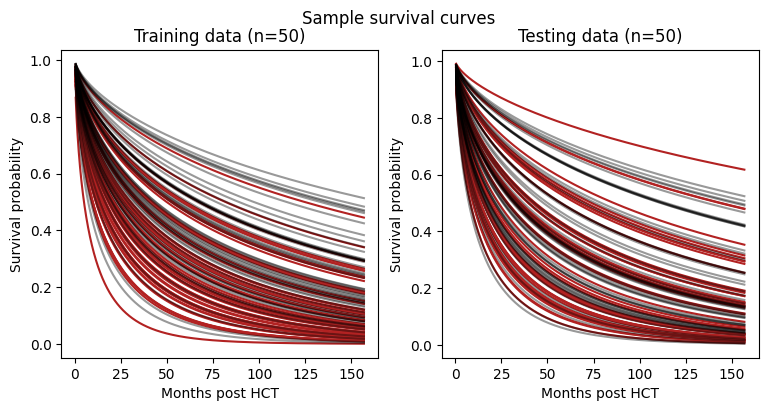

In [12]:
n_curves=50

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Sample survival curves')

efs_positive_ids=training_significant_features_df[training_significant_features_df['efs'] == 1].index
efs_negative_ids=training_significant_features_df[training_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=training_survival_functions[efs_negative_ids]
efs_positive_survival_functions=training_survival_functions[efs_positive_ids]

axs[0].set_title(f'Training data (n={n_curves})')

for i in range(n_curves):
    axs[0].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[0].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[0].set_xlabel('Months post HCT')
axs[0].set_ylabel('Survival probability')

efs_positive_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 1].index
efs_negative_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=testing_survival_functions[efs_negative_ids]
efs_positive_survival_functions=testing_survival_functions[efs_positive_ids]

axs[1].set_title(f'Testing data (n={n_curves})')

for i in range(n_curves):
    axs[1].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[1].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[1].set_xlabel('Months post HCT')
axs[1].set_ylabel('Survival probability')

plt.show()

### 4.2. Survival probability at study end

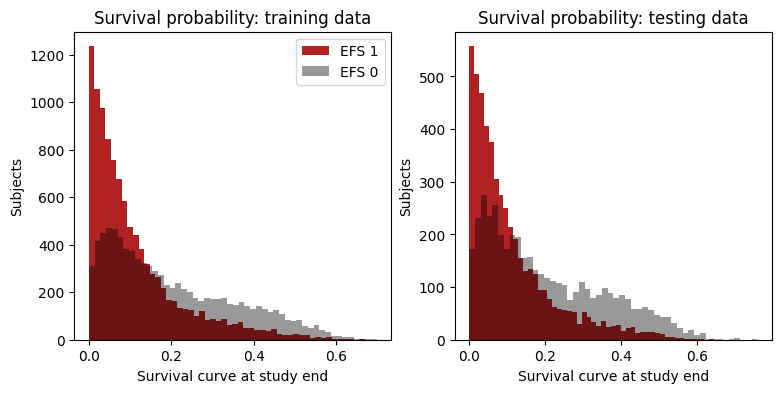

In [13]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Survival probability: training data')
axs[0].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Survival curve at study end')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Survival probability: testing data')
axs[1].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Survival curve at study end')
axs[1].set_ylabel('Subjects')

plt.show()

### 4.3. Expectation value

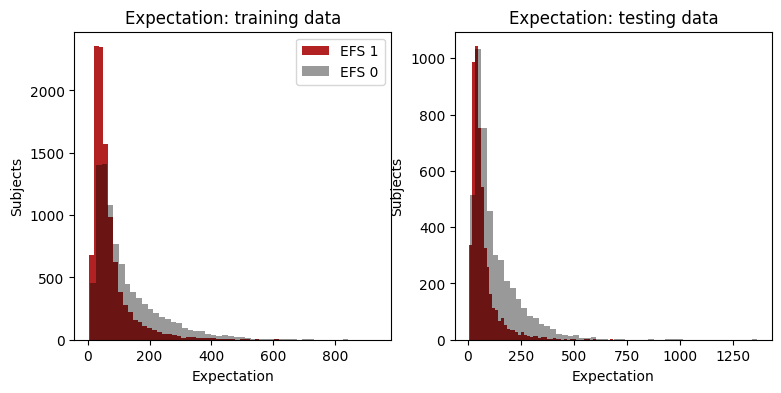

In [14]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Expectation: training data')
axs[0].hist(efs_positive_df['Expectation'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Expectation'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Expectation')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Expectation: testing data')
axs[1].hist(efs_positive_df['Expectation'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Expectation'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Expectation')
axs[1].set_ylabel('Subjects')

plt.show()

### 4.4. C-index scoring

In [15]:
scoring_results=helper_funcs.score_predictions(
    'WeibullAFT survival',
    testing_survival_df['Survival'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    testing_race_group,
    testing_survival_df.index
)

scoring_results=helper_funcs.score_predictions(
    'WeibullAFT',
    testing_survival_df['Expectation'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    testing_race_group,
    testing_survival_df.index,
    results=scoring_results
)

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,WeibullAFT survival,33.757979,0.621224,0.610643
1,WeibullAFT,114.742826,0.621224,0.610643


## 5. Save survival features

### 5.1. Prep. complete dataset for Weibull-AFT regression

In [16]:
efs_time=raw_data_df['efs_time']
efs=raw_data_df['efs']
raw_data_df=raw_data_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
raw_data_df['efs_time']=efs_time
raw_data_df['efs']=efs

### 5.2. Fit Weibull-AFT model

In [17]:
cph_model=WeibullAFTFitter()
cph_model.fit(raw_data_df, duration_col='efs_time', event_col='efs')
cph_model.print_summary()

<lifelines.WeibullAFTFitter: fitted with 28800 total observations, 13268 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
   number of observations = 28800
number of events observed = 15532
           log-likelihood = -69199.96
         time fit was run = 2025-02-23 16:09:27 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                               
lambda_ age_at_hct             -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
        cardiac                -0.25      0.78      0.02           -0.30           -0.21                0.74                0.81
        comorbidity_score      -0.06      0.95      0.00           -0.07           -0.05                0.94                0.95
        conditioning_intensity -0.07      0.93      0.01           -0.09           -0.05                0.92                0.95
        diabetes               -0.09      0.92      0.02           -0.12           -0.06                0.89                0.95
        donor_related           0.10      1.10      0.01            0.07            0.12                1.08                1.13
        dri_score              -0.06      0.94      0.01           -0.08           -0.05                0.92                0.95
        graft_type              0.38      1.47      0.06            0.27            0.49                1.31                1.64
        hepatic_severe          0.25      1.29      0.03            0.20            0.31                1.22                1.36
        hla_low_res_10          0.04      1.04      0.00            0.03            0.05                1.03                1.05
        hla_match_a_low         0.27      1.31      0.03            0.21            0.32                1.24                1.38
        hla_match_dqb1_high    -0.20      0.82      0.03           -0.26           -0.15                0.77                0.86
        hla_match_dqb1_low     -0.20      0.82      0.03           -0.26           -0.14                0.77                0.87
        in_vivo_tcd             0.23      1.26      0.01            0.21            0.26                1.23                1.30
        karnofsky_score         0.07      1.07      0.01            0.06            0.09                1.06                1.09
        mrd_hct                 0.07      1.08      0.02            0.04            0.11                1.04                1.12
        peptic_ulcer            0.24      1.28      0.04            0.17            0.32                1.18                1.38
        prim_disease_hct        0.02      1.02      0.00            0.02            0.03                1.02                1.03
        prod_type              -0.36      0.70      0.06           -0.47           -0.25                0.63                0.78
        psych_disturb          -0.12      0.88      0.02           -0.16           -0.09                0.85                0.91
        pulm_moderate          -0.07      0.93      0.02           -0.10           -0.04                0.90                0.96
        pulm_severe            -0.21      0.81      0.02           -0.25           -0.17                0.78                0.85
        sex_match               0.06      1.06      0.01            0.04            0.08                1.04                1.08
        tbi_status              0.08      1.08      0.01            0.05            0.11                1.06                1.11
        tce_match              -0.09      0.91      0.01           -0.11           -0.06                0.89                0.94
        Intercept               4.17     64.66      0.10            3.97            4.37               52.75               79.27
rho_    Intercept              -0.39      0.68    

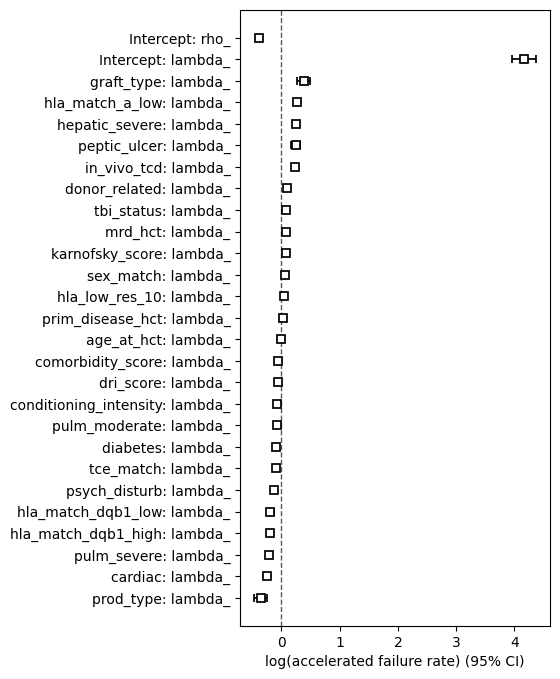

In [18]:
fig=plt.figure(figsize=[4,8])
cph_model.plot(figure=fig)
plt.show()

### 5.3. Get study end survival probabilities

In [19]:
survival_functions=waft_model.predict_survival_function(raw_data_df)
survival_probabilities=survival_functions.iloc[-1]

### 5.4. Get partial hazards

In [20]:
expectations=cph_model.predict_expectation(raw_data_df)

### 5.5. Save predicted survival curves & probabilities

In [21]:
results_df=pd.DataFrame.from_dict({'Survival': survival_probabilities, 'Expecation': expectations})
results_df.index=raw_data_df.index
results_df.to_parquet(survival_probabilities_file)
results_df.head()

,Survival,Expecation
ID,,
0,0.459287,286.417958
1,0.034960,35.204533
2,0.424843,252.222701
3,0.207487,106.641157
4,0.263016,131.942774
